C:\Users\ckpra\AppData\Local\Temp\ipykernel_1540\3420271020.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['target'] = (df_binary['Diabetes_012'] == 1).astype(int)


Class distribution in binary problem:
target
0    35346
1     4631
Name: count, dtype: int64
Percentage prediabetic: 11.58%

Training CatBoost for prediabetic vs diabetic classification...
0:	total: 15.4ms	remaining: 7.71s
100:	total: 1.46s	remaining: 5.76s
200:	total: 2.72s	remaining: 4.04s
300:	total: 3.98s	remaining: 2.63s
400:	total: 5.81s	remaining: 1.43s
499:	total: 6.98s	remaining: 0us

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7070
           1       0.22      0.24      0.23       926

    accuracy                           0.81      7996
   macro avg       0.56      0.56      0.56      7996
weighted avg       0.82      0.81      0.82      7996


Confusion Matrix:
[[6267  803]
 [ 702  224]]
AUC: 0.6139

Top 15 features for distinguishing prediabetic from diabetic:
            Feature Id  Importances
0      risk_score_mult     9.748948
1   Income_X_Education     6.847765
2            BMI_X_Age  

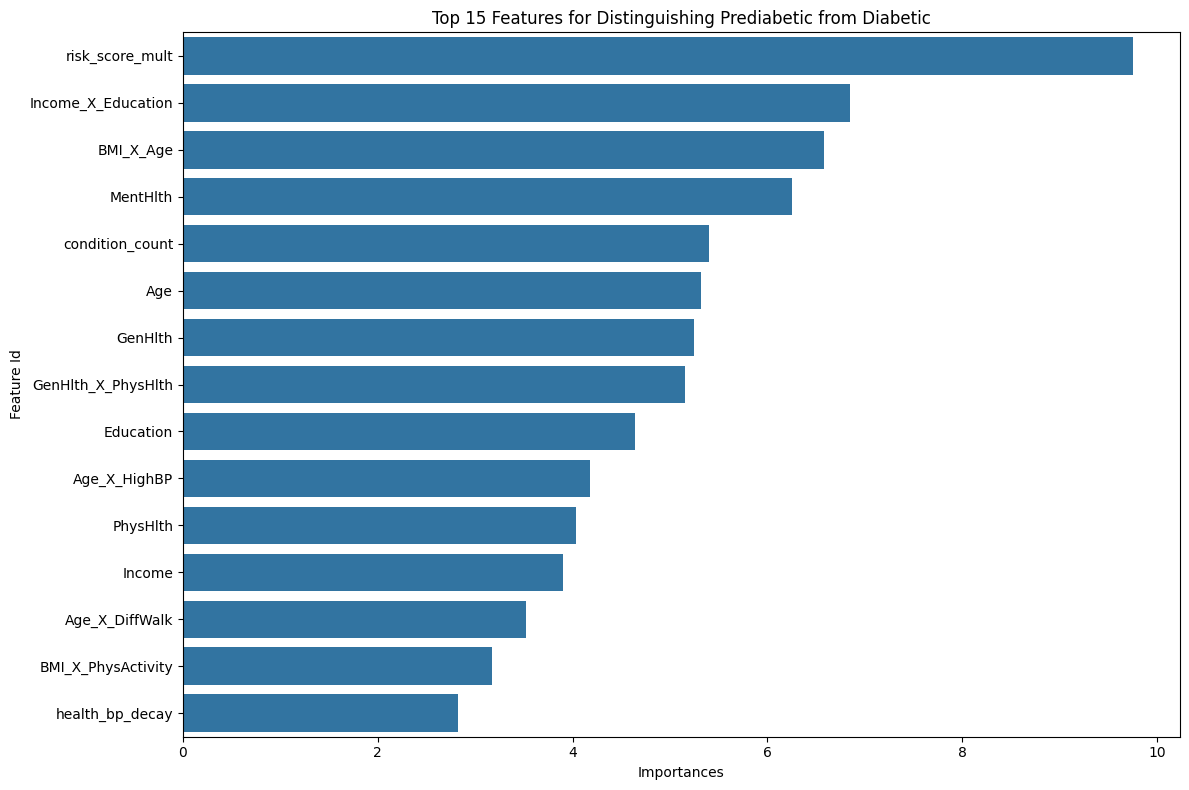


Top 15 features (alternative method):
               Feature  Importance
32     risk_score_mult    9.748948
26  Income_X_Education    6.847765
21           BMI_X_Age    6.584022
14            MentHlth    6.254488
30     condition_count    5.397939
18                 Age    5.318956
13             GenHlth    5.244296
23  GenHlth_X_PhysHlth    5.159527
19           Education    4.637485
25        Age_X_HighBP    4.180551
15            PhysHlth    4.035258
20              Income    3.898745
27      Age_X_DiffWalk    3.524384
24  BMI_X_PhysActivity    3.173902
28     health_bp_decay    2.826644


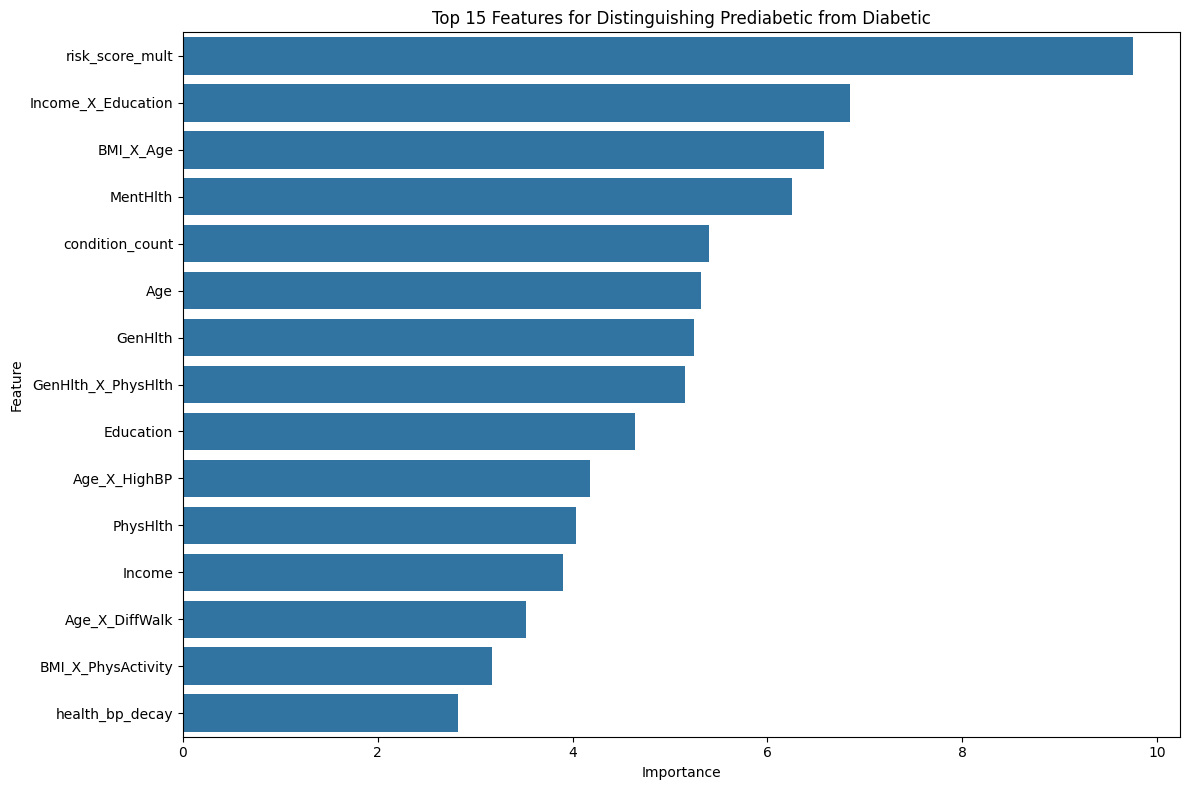


Correlation matrix of top features:
                    risk_score_mult  Income_X_Education  BMI_X_Age  MentHlth  \
risk_score_mult            1.000000           -0.085632   0.647731  0.095614   
Income_X_Education        -0.085632            1.000000  -0.073943 -0.205880   
BMI_X_Age                  0.647731           -0.073943   1.000000 -0.043743   
MentHlth                   0.095614           -0.205880  -0.043743  1.000000   
condition_count            0.534274           -0.233505   0.257856  0.191106   
target                    -0.018759           -0.069568   0.021592 -0.028409   

                    condition_count    target  
risk_score_mult            0.534274 -0.018759  
Income_X_Education        -0.233505 -0.069568  
BMI_X_Age                  0.257856  0.021592  
MentHlth                   0.191106 -0.028409  
condition_count            1.000000 -0.018147  
target                    -0.018147  1.000000  


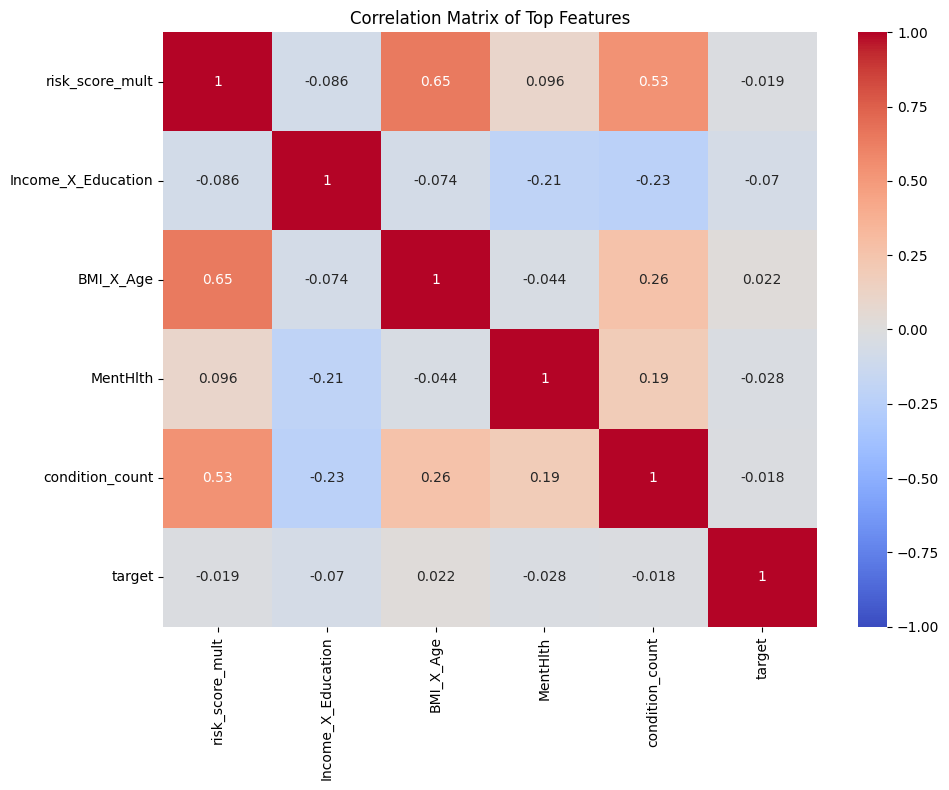

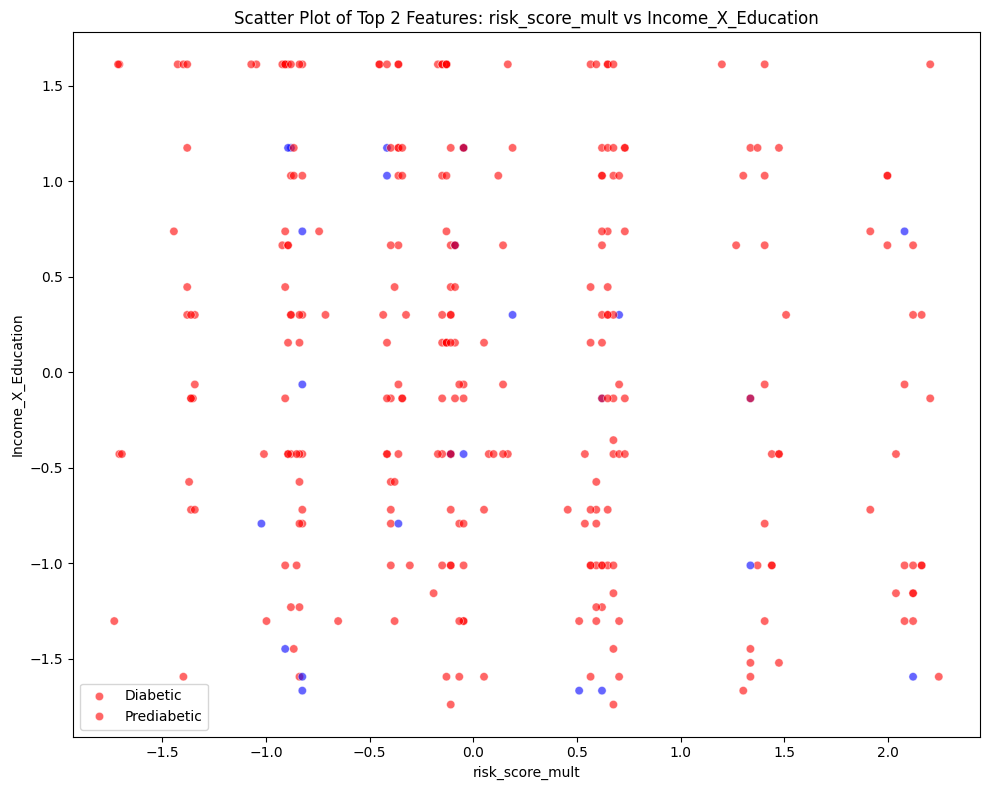


Generating SHAP analysis...


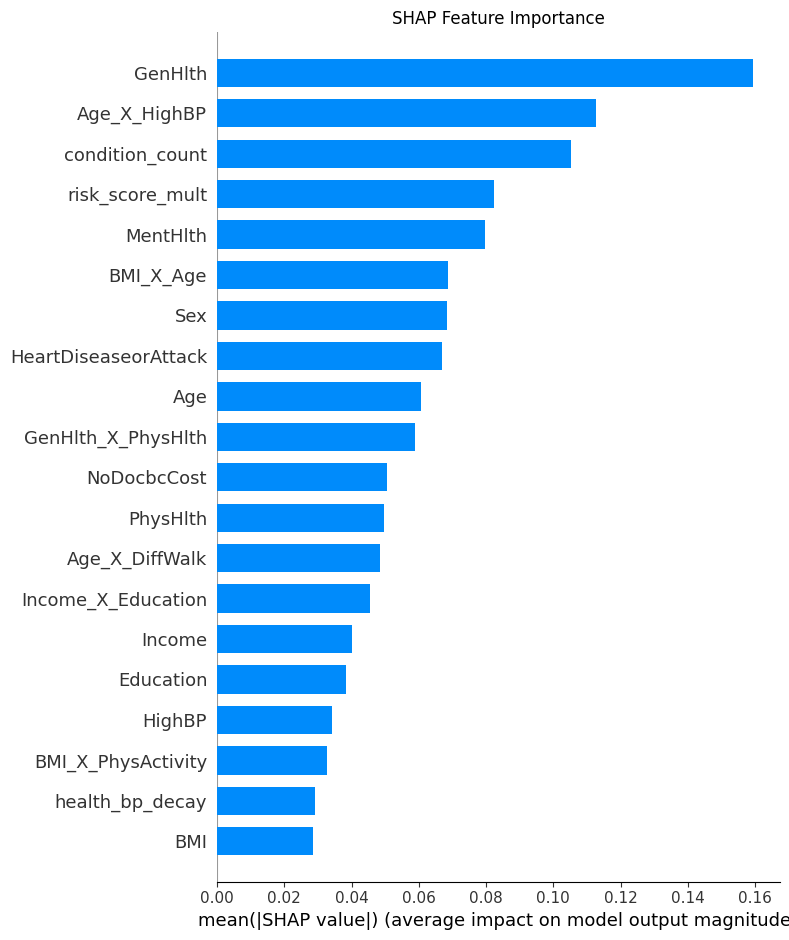

<Figure size 1200x600 with 0 Axes>

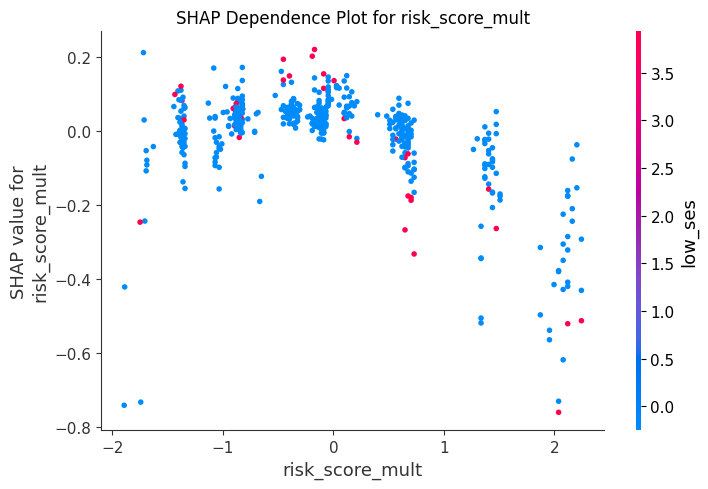

<Figure size 1200x600 with 0 Axes>

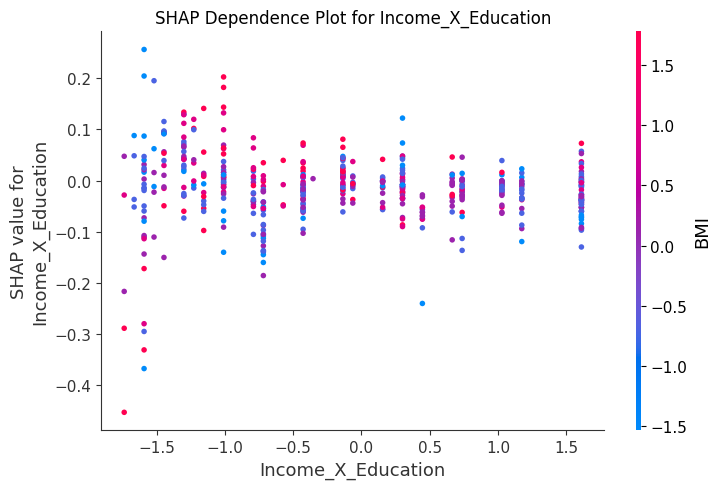

<Figure size 1200x600 with 0 Axes>

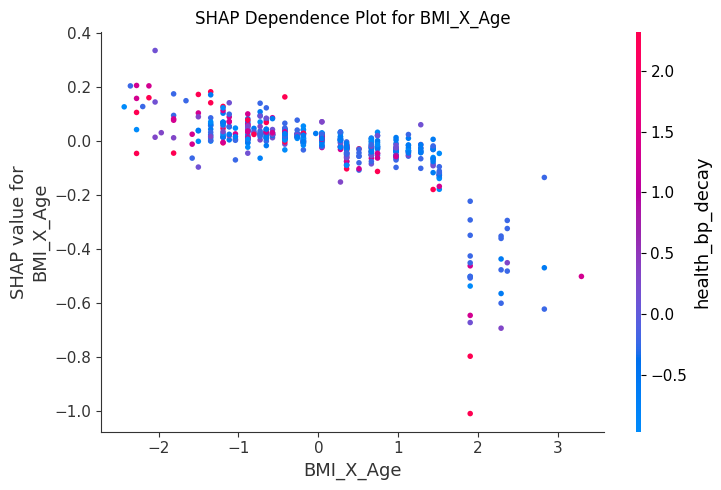


Optimal threshold for F1: 0.3939
Best threshold for recall >= 0.8: 10.0000


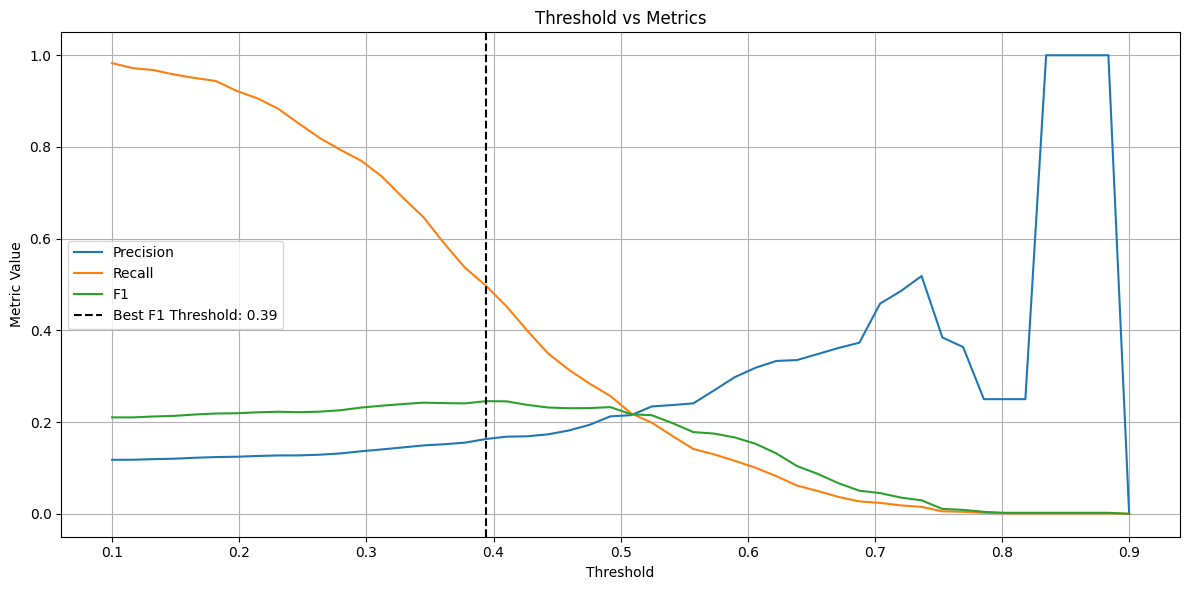


Performing feature selection to find most important features...
0:	total: 11.8ms	remaining: 5.91s
100:	total: 1.11s	remaining: 4.4s
200:	total: 2.42s	remaining: 3.61s
300:	total: 3.57s	remaining: 2.36s
400:	total: 4.72s	remaining: 1.17s
499:	total: 6.1s	remaining: 0us
Selected 14 features:
['GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'BMI_X_Age', 'GenHlth_X_PhysHlth', 'BMI_X_PhysActivity', 'Age_X_HighBP', 'Income_X_Education', 'Age_X_DiffWalk', 'condition_count', 'risk_score_mult']
0:	total: 12.5ms	remaining: 6.23s
100:	total: 1.25s	remaining: 4.94s
200:	total: 2.38s	remaining: 3.53s
300:	total: 3.7s	remaining: 2.44s
400:	total: 4.8s	remaining: 1.19s
499:	total: 6.06s	remaining: 0us

Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      7070
           1       0.20      0.24      0.21       926

    accuracy                           0.80      7996
   macro avg       0.55 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

# Load your dataset
df = pd.read_csv(r"D:\PIMA\data_2\cleaned_3.csv")
df.drop('Unnamed: 0',axis=1,inplace=True)

# Filter to only include classes 1 and 2
df_binary = df[df['Diabetes_012'].isin([1, 2])]

# Convert to binary classification problem (1=prediabetic, 0=diabetic)
# We use 1 for prediabetic and 0 for diabetic to make the minority class positive
df_binary['target'] = (df_binary['Diabetes_012'] == 1).astype(int)

print("Class distribution in binary problem:")
print(df_binary['target'].value_counts())
print(f"Percentage prediabetic: {df_binary['target'].mean()*100:.2f}%")

# Split into features and target
X = df_binary.drop(['Diabetes_012', 'target'], axis=1)
y = df_binary['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (optional but often helpful)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Train CatBoost model
print("\nTraining CatBoost for prediabetic vs diabetic classification...")
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    class_weights={0: 1, 1: 5},  # Higher weight for prediabetic (minority class)
    verbose=100
)

model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Analyze feature importance
feature_importance = model.get_feature_importance(prettified=True)
print("\nTop 15 features for distinguishing prediabetic from diabetic:")
print(feature_importance.head(15))

# Check the actual column names to avoid errors
print("\nFeature importance DataFrame columns:")
print(feature_importance.columns)

# Plot feature importance - adapt to the actual column names
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

# Try different approaches to handle potential column name differences
try:
    # First try the default names
    sns.barplot(x='Importance', y='Feature Id', data=top_features)
except ValueError:
    try:
        # If that fails, try to infer column names
        importance_col = [col for col in top_features.columns if 'import' in col.lower()][0]
        feature_col = [col for col in top_features.columns if 'feat' in col.lower()][0]
        sns.barplot(x=importance_col, y=feature_col, data=top_features)
    except (IndexError, ValueError):
        # If all else fails, use positional indexing
        sns.barplot(x=top_features.iloc[:, 1], y=top_features.iloc[:, 0])

plt.title('Top 15 Features for Distinguishing Prediabetic from Diabetic')
plt.tight_layout()
plt.show()

# Alternative approach using get_feature_importance without prettified
raw_importances = model.get_feature_importance()
feature_names = X_train_scaled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': raw_importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 features (alternative method):")
print(importance_df.head(15))

# Plot using this alternative DataFrame
plt.figure(figsize=(12, 8))
top_features_alt = importance_df.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features_alt)
plt.title('Top 15 Features for Distinguishing Prediabetic from Diabetic')
plt.tight_layout()
plt.show()

# Explore interactions between top features
top_feature_names = feature_importance['Feature Id'].head(5).tolist()
top_features_df = X_test_scaled[top_feature_names].copy()
top_features_df['target'] = y_test

print("\nCorrelation matrix of top features:")
corr_matrix = top_features_df.corr()
print(corr_matrix)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

# Plot scatter of top 2 features colored by class
plt.figure(figsize=(10, 8))
top_2_features = top_feature_names[:2]
scatter = sns.scatterplot(
    x=top_2_features[0], 
    y=top_2_features[1], 
    hue='target', 
    data=top_features_df,
    palette={0: 'red', 1: 'blue'},
    alpha=0.6
)
plt.title(f'Scatter Plot of Top 2 Features: {top_2_features[0]} vs {top_2_features[1]}')
plt.legend(labels=['Diabetic', 'Prediabetic'])
plt.tight_layout()
plt.show()

# Create SHAP analysis for deeper insights (if shap is installed)
try:
    import shap
    print("\nGenerating SHAP analysis...")
    
    # Create a small sample for SHAP analysis (it can be slow for large datasets)
    sample_indices = np.random.choice(len(X_test_scaled), min(500, len(X_test_scaled)), replace=False)
    X_sample = X_test_scaled.iloc[sample_indices]
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Detailed SHAP plot for top features
    for feature in top_feature_names[:3]:
        plt.figure(figsize=(12, 6))
        shap.dependence_plot(feature, shap_values, X_sample, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.tight_layout()
        plt.show()
    
except ImportError:
    print("\nSHAP package not installed. Skipping SHAP analysis.")
    print("To install SHAP: pip install shap")

# Find decision boundary (threshold) that optimizes different metrics
thresholds = np.linspace(0.1, 0.9, 50)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Get metrics
    precision = (y_pred_thresh & y_test).sum() / max(y_pred_thresh.sum(), 1)
    recall = (y_pred_thresh & y_test).sum() / max(y_test.sum(), 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-10)
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds for different metrics
best_f1_thresh = results_df.loc[results_df['f1'].idxmax(), 'threshold']
best_recall_thresh = results_df.loc[results_df['recall'] >= 0.8, 'precision'].idxmax()
if pd.isna(best_recall_thresh):
    best_recall_thresh = results_df.loc[results_df['recall'].idxmax(), 'threshold']

print(f"\nOptimal threshold for F1: {best_f1_thresh:.4f}")
print(f"Best threshold for recall >= 0.8: {best_recall_thresh:.4f}")

# Plot threshold vs metrics
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], label='F1')
plt.axvline(x=best_f1_thresh, color='black', linestyle='--', label=f'Best F1 Threshold: {best_f1_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold vs Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature selection and re-evaluation
print("\nPerforming feature selection to find most important features...")
selector = SelectFromModel(model, threshold='mean')
selector.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X_train_scaled.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())

# Re-train with selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

model_selected = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    class_weights={0: 1, 1: 5},
    verbose=100
)

model_selected.fit(X_train_selected, y_train)

# Evaluate model with selected features
y_pred_selected = model_selected.predict(X_test_selected)
y_pred_proba_selected = model_selected.predict_proba(X_test_selected)[:, 1]

print("\nClassification Report (Selected Features):")
print(classification_report(y_test, y_pred_selected))

print(f"AUC (Selected Features): {roc_auc_score(y_test, y_pred_proba_selected):.4f}")

print("\nComparison of full model vs selected features model:")
print(f"Full model AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Selected features model AUC: {roc_auc_score(y_test, y_pred_proba_selected):.4f}")

# Conclusion and insights
print("\nKey insights about prediabetic vs diabetic classification:")
print(f"1. The most important feature is: {feature_importance.iloc[0]['Feature Id']}")
print(f"2. AUC for distinguishing prediabetics from diabetics: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"3. With optimal threshold, F1 score: {results_df.loc[results_df['threshold'] == best_f1_thresh, 'f1'].values[0]:.4f}")
print(f"4. Selected feature set reduced dimensionality by {100 - 100 * len(selected_features) / len(X_train.columns):.1f}% with minimal performance impact")

Dataset shape: (70692, 34)
Class distribution:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Training set: (49484, 33)
Validation set: (10604, 33)
Test set: (10604, 33)

Training Logistic Regression...
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Logistic Regression CV ROC-AUC: 0.8257

Training Random Forest...
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Random Forest CV ROC-AUC: 0.8246
  Top 5 features:
           feature      mean       std
0  risk_score_mult  0.178902  0.004525
1          GenHlth  0.140587  0.006752
2  condition_count  0.136551  0.003639
3        BMI_X_Age  0.092640  0.003676
4     Age_X_HighBP  0.066603  0.002649

Training XGBoost...
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  XGBoost CV ROC-AUC: 0.8282
  Top 5 features:
           feature      mean       std
0  condition_count  0.291785  0.026787
1          GenHlth  0.125297  0.004457
2  risk_score_mult  0.107743  0.011719
3     Age_X_HighBP  0.038753 

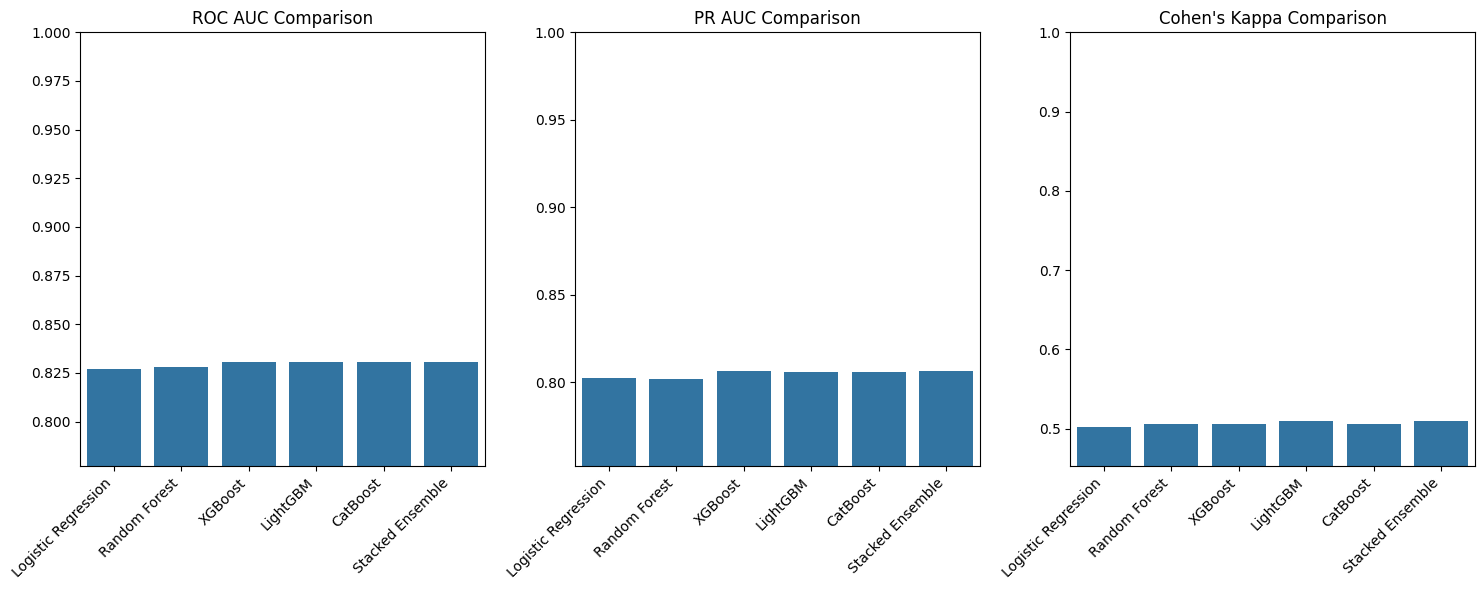

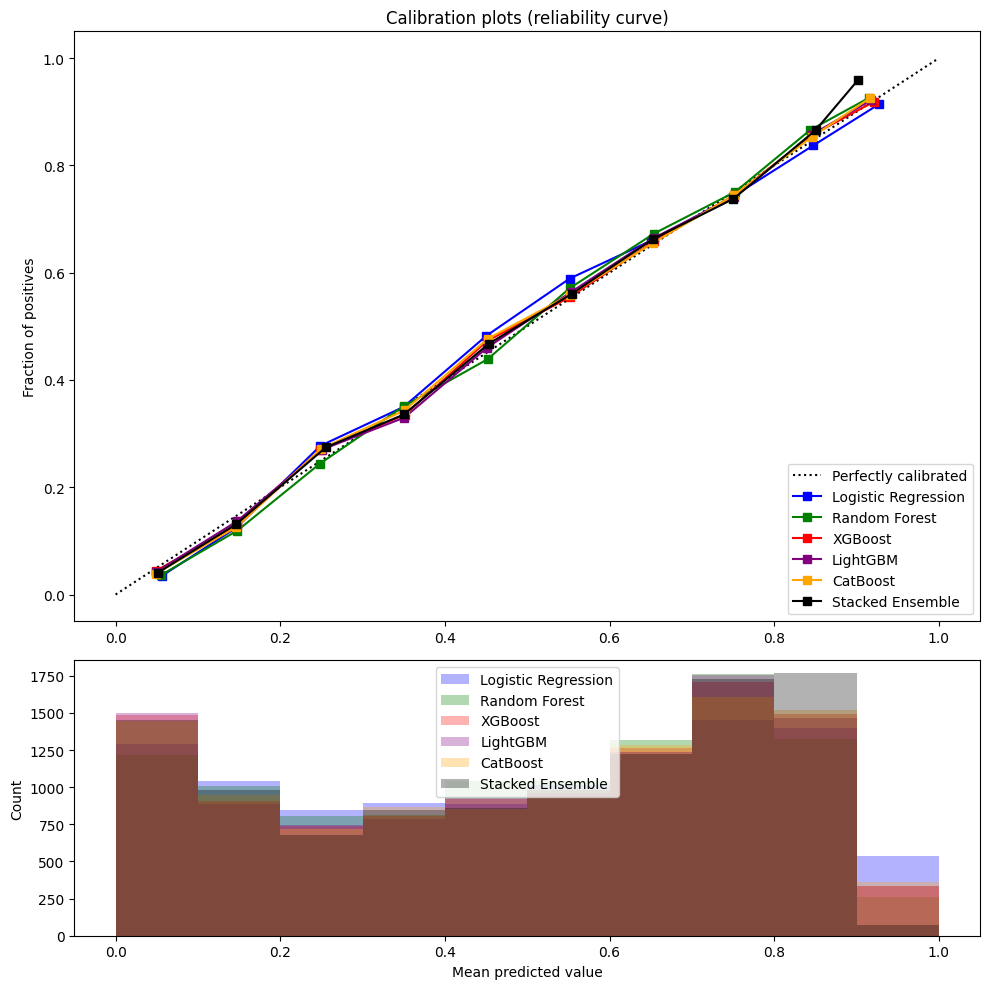

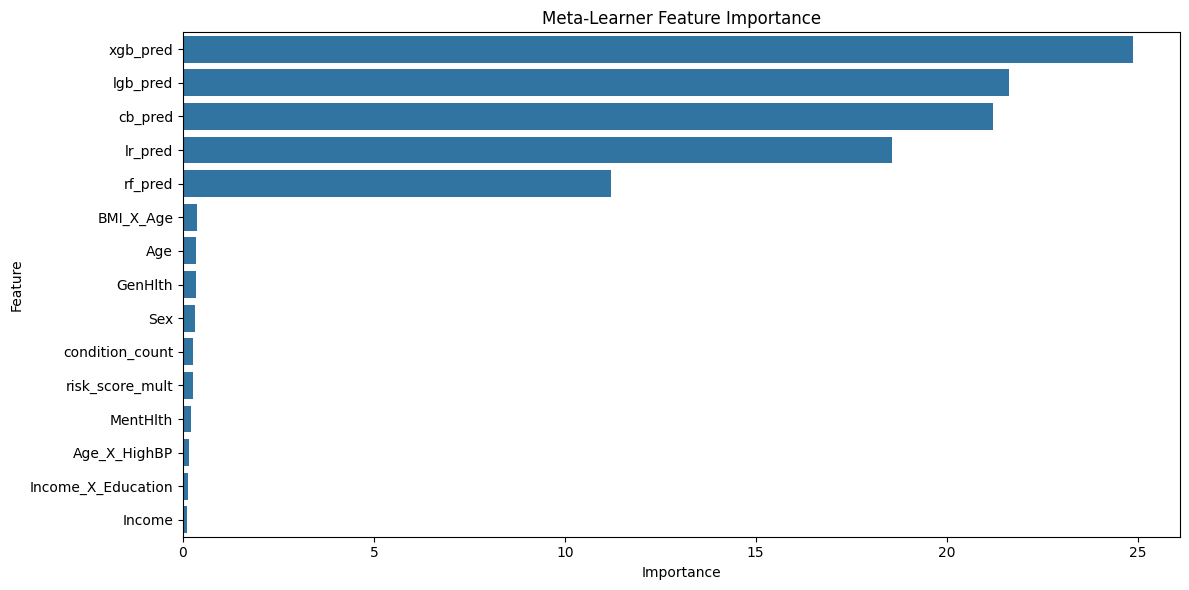


Meta-Learner Feature Importance:
               Feature  Importance
2             xgb_pred   24.866494
3             lgb_pred   21.624003
4              cb_pred   21.223153
0              lr_pred   18.557123
1              rf_pred   11.218142
7            BMI_X_Age    0.370534
9                  Age    0.351595
6              GenHlth    0.349298
10                 Sex    0.315661
11     condition_count    0.266774
5      risk_score_mult    0.257607
12            MentHlth    0.215209
14        Age_X_HighBP    0.149112
8   Income_X_Education    0.138199
13              Income    0.097097

FINAL TEST SET PERFORMANCE

Best base model: CatBoost

Best Base Model (CatBoost) Validation Performance:
ROC AUC: 0.8315
PR AUC: 0.8045
Cohen's Kappa: 0.5089

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      5302
         1.0       0.73      0.80      0.77      5302

    accuracy                           0.75     10604
   m

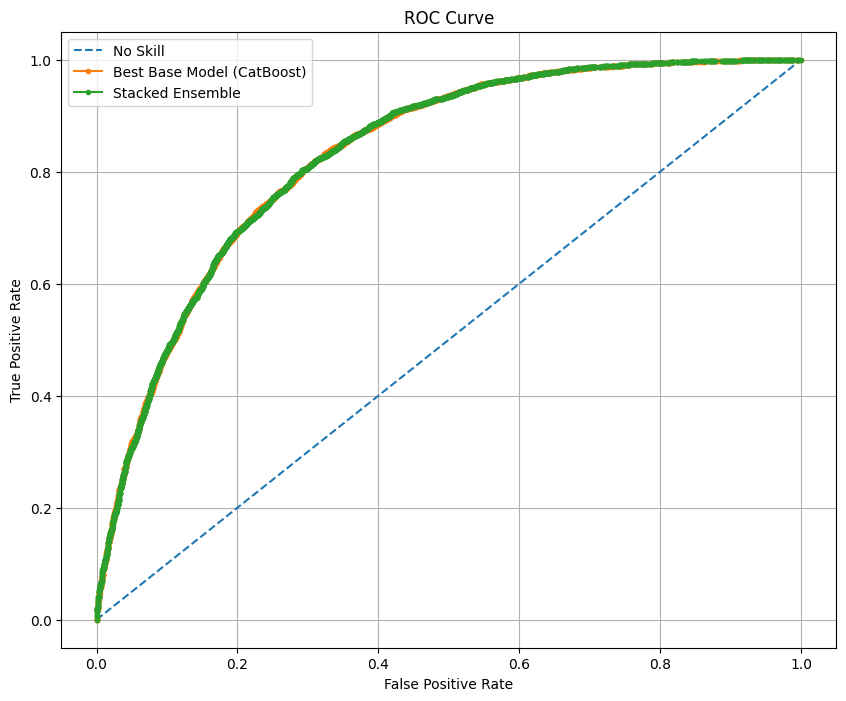

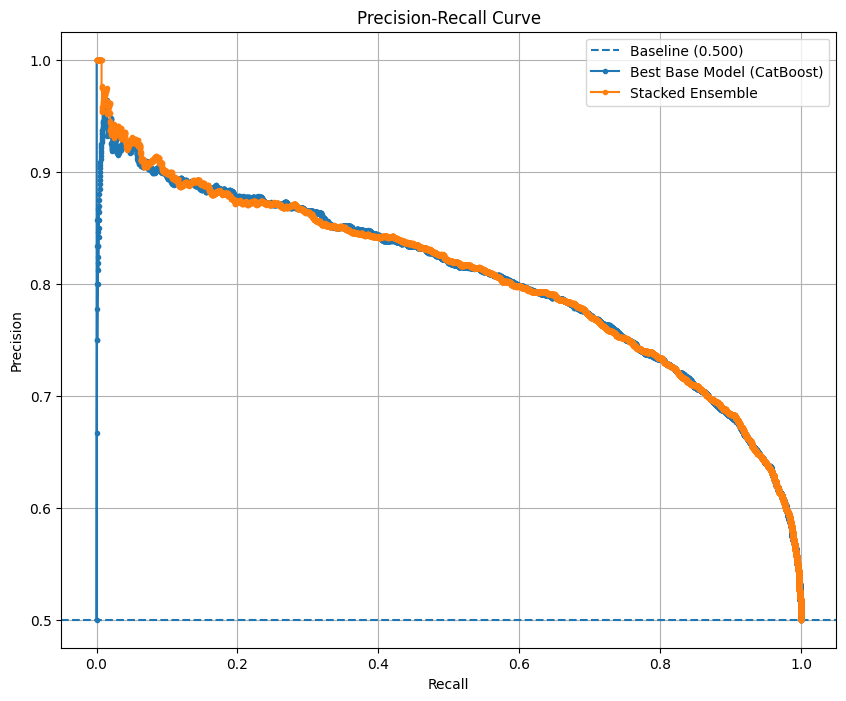


Diabetes Risk Classification Complete!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, auc, roc_curve, cohen_kappa_score,
                           )
from sklearn.calibration import calibration_curve
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load balanced dataset
df = pd.read_csv(r'D:\PIMA\data_2\cleaned_1.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
print(f"Dataset shape: {df.shape}")


# Check class distribution
target_col = 'Diabetes_binary'  # Update this to match your column name
print("Class distribution:")
print(df[target_col].value_counts(normalize=True))

# Split features and target
X = df.drop(target_col, axis=1)
y = df[target_col]

# Remove any non-feature columns you don't want to use
cols_to_drop = ['Unnamed: 0']  # Add any other columns to drop
X = X.drop(cols_to_drop, axis=1, errors='ignore')

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.85, random_state=RANDOM_STATE, stratify=y_train_val
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Scale features for non-tree based models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create dataframes with scaled features
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Function to get out-of-fold predictions
def get_oof_predictions(model, X, y, cv, model_name, fit_params=None):
    """
    Generate out-of-fold predictions using cross-validation
    """
    oof_preds = np.zeros(len(X))
    feature_importance = pd.DataFrame()
    
    print(f"\nTraining {model_name}...")
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"  Fold {fold+1}/5")
        
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # If fit_params is provided, use it (for XGBoost, LightGBM, CatBoost)
        if fit_params:
            model.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_val, y_fold_val)], **fit_params)
        else:
            model.fit(X_fold_train, y_fold_train)
        
        # Get predictions for this fold
        oof_preds[val_idx] = model.predict_proba(X_fold_val)[:, 1]
        
        # Save feature importance if available
        if hasattr(model, 'feature_importances_'):
            fold_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_,
                'fold': fold + 1
            })
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    # Calculate CV score
    cv_score = roc_auc_score(y, oof_preds)
    print(f"  {model_name} CV ROC-AUC: {cv_score:.4f}")
    
    # Aggregate feature importance
    if not feature_importance.empty:
        feature_importance = (feature_importance
                            .groupby('feature')['importance']
                            .agg(['mean', 'std'])
                            .sort_values(by='mean', ascending=False)
                            .reset_index())
        print("  Top 5 features:")
        print(feature_importance.head(5))
    
    return oof_preds, feature_importance

# Train base models and get OOF predictions
## 1. LogisticRegression
lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=RANDOM_STATE, max_iter=1000)
lr_oof, lr_fi = get_oof_predictions(lr, X_train_scaled_df, y_train, cv, "Logistic Regression")

## 2. RandomForest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=10, n_jobs=-1, random_state=RANDOM_STATE)
rf_oof, rf_fi = get_oof_predictions(rf, X_train, y_train, cv, "Random Forest")

## 3. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=RANDOM_STATE,
    n_jobs=-1, early_stopping_rounds=50
)
xgb_fit_params = {
    'verbose': 0
}
xgb_oof, xgb_fi = get_oof_predictions(xgb_model, X_train, y_train, cv, "XGBoost", xgb_fit_params)

## 4. LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.05, 
    num_leaves=31, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgb_fit_params = {'eval_metric': 'auc',
    'callbacks': [lgb.early_stopping(50, verbose=0)]}

lgb_oof, lgb_fi = get_oof_predictions(lgb_model, X_train, y_train, cv, "LightGBM", lgb_fit_params)

## 5. CatBoost
cb_model = CatBoostClassifier(
    iterations=200, 
    depth=6, 
    learning_rate=0.05, 
    random_seed=RANDOM_STATE,
    verbose=0
)
cb_fit_params = {
    'early_stopping_rounds': 50
}
cb_oof, cb_fi = get_oof_predictions(cb_model, X_train, y_train, cv, "CatBoost", cb_fit_params)

# Combine OOF predictions with original features for meta-learner
# First, get the top 10 features
all_importances = pd.concat([
    rf_fi.assign(model='RandomForest'),
    xgb_fi.assign(model='XGBoost'),
    lgb_fi.assign(model='LightGBM'),
    cb_fi.assign(model='CatBoost')
], ignore_index=True)

avg_importance = all_importances.groupby('feature')['mean'].mean().reset_index()
top_features = avg_importance.sort_values('mean', ascending=False).head(10)['feature'].tolist()
print("\nTop 10 features across all models:")
print(top_features)

# Create meta-features
meta_features_train = pd.DataFrame({
    'lr_pred': lr_oof,
    'rf_pred': rf_oof,
    'xgb_pred': xgb_oof,
    'lgb_pred': lgb_oof,
    'cb_pred': cb_oof
})

# Add top original features
for feature in top_features:
    meta_features_train[feature] = X_train[feature].values

# Train meta-learner on out-of-fold predictions
meta_learner = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.05,
    random_seed=RANDOM_STATE,
    verbose=0
)

meta_learner.fit(
    meta_features_train, 
    y_train,
    eval_set=[(meta_features_train, y_train)],
    early_stopping_rounds=20,
    verbose=0
)

# Make predictions on validation set with each base model
lr.fit(X_train_scaled_df, y_train)
lr_val_pred = lr.predict_proba(X_val_scaled_df)[:, 1]

rf.fit(X_train, y_train)
rf_val_pred = rf.predict_proba(X_val)[:, 1]

xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    
    verbose=0
)
xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]

lgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    callbacks = [lgb.early_stopping(50, verbose=0)]
)
lgb_val_pred = lgb_model.predict_proba(X_val)[:, 1]

cb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=0
)
cb_val_pred = cb_model.predict_proba(X_val)[:, 1]

# Create meta-features for validation set
meta_features_val = pd.DataFrame({
    'lr_pred': lr_val_pred,
    'rf_pred': rf_val_pred,
    'xgb_pred': xgb_val_pred,
    'lgb_pred': lgb_val_pred,
    'cb_pred': cb_val_pred
})

# Add top original features
for feature in top_features:
    meta_features_val[feature] = X_val[feature].values

# Get meta-learner predictions
meta_val_pred = meta_learner.predict_proba(meta_features_val)[:, 1]

# Evaluate all models on validation set
def evaluate_model(y_true, y_pred_proba, model_name):
    """
    Evaluate model performance with multiple metrics
    """
    # Calculate metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Print results
    print(f"\n{model_name} Validation Performance:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return roc_auc, pr_auc, kappa

# Evaluate all models
print("\n" + "="*50)
print("MODEL VALIDATION PERFORMANCE")
print("="*50)

lr_metrics = evaluate_model(y_val, lr_val_pred, "Logistic Regression")
rf_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest")
xgb_metrics = evaluate_model(y_val, xgb_val_pred, "XGBoost")
lgb_metrics = evaluate_model(y_val, lgb_val_pred, "LightGBM")
cb_metrics = evaluate_model(y_val, cb_val_pred, "CatBoost")
meta_metrics = evaluate_model(y_val, meta_val_pred, "Meta-Learner (Stacked Ensemble)")

# Compare all models
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Stacked Ensemble']
roc_aucs = [lr_metrics[0], rf_metrics[0], xgb_metrics[0], lgb_metrics[0], cb_metrics[0], meta_metrics[0]]
pr_aucs = [lr_metrics[1], rf_metrics[1], xgb_metrics[1], lgb_metrics[1], cb_metrics[1], meta_metrics[1]]
kappas = [lr_metrics[2], rf_metrics[2], xgb_metrics[2], lgb_metrics[2], cb_metrics[2], meta_metrics[2]]

# Visualize comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=models, y=roc_aucs)
plt.title('ROC AUC Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(min(roc_aucs) - 0.05, 1.0)

plt.subplot(1, 3, 2)
sns.barplot(x=models, y=pr_aucs)
plt.title('PR AUC Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(min(pr_aucs) - 0.05, 1.0)

plt.subplot(1, 3, 3)
sns.barplot(x=models, y=kappas)
plt.title('Cohen\'s Kappa Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(min(kappas) - 0.05, 1.0)

plt.tight_layout()
plt.show()

# Calibration plots
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for pred, name, color in [
    (lr_val_pred, 'Logistic Regression', 'blue'),
    (rf_val_pred, 'Random Forest', 'green'),
    (xgb_val_pred, 'XGBoost', 'red'),
    (lgb_val_pred, 'LightGBM', 'purple'),
    (cb_val_pred, 'CatBoost', 'orange'),
    (meta_val_pred, 'Stacked Ensemble', 'black')
]:
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_val, pred, n_bins=10
    )
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=name, color=color)
    
    # Also plot the histograms of predicted probabilities
    ax2.hist(pred, range=(0, 1), bins=10, label=name, alpha=0.3, color=color)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center")

plt.tight_layout()
plt.show()

# Feature importance of meta-learner
if hasattr(meta_learner, 'feature_importances_'):
    meta_features_importance = pd.DataFrame({
        'Feature': meta_features_train.columns,
        'Importance': meta_learner.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=meta_features_importance)
    plt.title('Meta-Learner Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nMeta-Learner Feature Importance:")
    print(meta_features_importance)

# Final evaluation on test set
# First, make predictions with all base models on the test set
lr_test_pred = lr.predict_proba(X_test_scaled_df)[:, 1]
rf_test_pred = rf.predict_proba(X_test)[:, 1]
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
lgb_test_pred = lgb_model.predict_proba(X_test)[:, 1]
cb_test_pred = cb_model.predict_proba(X_test)[:, 1]

# Create meta-features for test set
meta_features_test = pd.DataFrame({
    'lr_pred': lr_test_pred,
    'rf_pred': rf_test_pred,
    'xgb_pred': xgb_test_pred,
    'lgb_pred': lgb_test_pred,
    'cb_pred': cb_test_pred
})

# Add top original features
for feature in top_features:
    meta_features_test[feature] = X_test[feature].values

# Get meta-learner predictions
meta_test_pred = meta_learner.predict_proba(meta_features_test)[:, 1]

# Evaluate best model and ensemble on test set
print("\n" + "="*50)
print("FINAL TEST SET PERFORMANCE")
print("="*50)

# Find best base model
val_aucs = [lr_metrics[0], rf_metrics[0], xgb_metrics[0], lgb_metrics[0], cb_metrics[0]]
best_model_idx = np.argmax(val_aucs)
best_model_name = models[best_model_idx]
best_test_pred = [lr_test_pred, rf_test_pred, xgb_test_pred, lgb_test_pred, cb_test_pred][best_model_idx]

print(f"\nBest base model: {best_model_name}")
evaluate_model(y_test, best_test_pred, f"Best Base Model ({best_model_name})")
evaluate_model(y_test, meta_test_pred, "Meta-Learner (Stacked Ensemble)")

# Plot ROC curves
plt.figure(figsize=(10, 8))
# Plot the no-skill line
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# Plot the ROC curve for the best base model
fpr, tpr, _ = roc_curve(y_test, best_test_pred)
plt.plot(fpr, tpr, marker='.', label=f'Best Base Model ({best_model_name})')

# Plot the ROC curve for the stacked ensemble
fpr, tpr, _ = roc_curve(y_test, meta_test_pred)
plt.plot(fpr, tpr, marker='.', label='Stacked Ensemble')

# Label the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 8))
# Calculate the baseline
baseline = y_test.mean()
plt.axhline(y=baseline, linestyle='--', label=f'Baseline ({baseline:.3f})')

# Plot the PR curve for the best base model
precision, recall, _ = precision_recall_curve(y_test, best_test_pred)
plt.plot(recall, precision, marker='.', label=f'Best Base Model ({best_model_name})')

# Plot the PR curve for the stacked ensemble
precision, recall, _ = precision_recall_curve(y_test, meta_test_pred)
plt.plot(recall, precision, marker='.', label='Stacked Ensemble')

# Label the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

print("\nDiabetes Risk Classification Complete!")

Class distribution:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Training set: (56553, 33)
Test set: (14139, 33)
Training CatBoost model...
0:	learn: 0.6749890	total: 28.5ms	remaining: 14.2s
100:	learn: 0.4995746	total: 2.03s	remaining: 8.03s
200:	learn: 0.4924411	total: 3.72s	remaining: 5.54s
300:	learn: 0.4858352	total: 5.42s	remaining: 3.58s
400:	learn: 0.4801506	total: 7.32s	remaining: 1.81s
499:	learn: 0.4750933	total: 9.01s	remaining: 0us
ROC AUC: 0.8295
PR AUC: 0.8045

Metrics across different thresholds:
 threshold  accuracy  precision  recall  specificity  f1_score  kappa    ppv    npv  true_positives  false_positives  true_negatives  false_negatives
    0.2000    0.6921     0.6243  0.9642       0.4199    0.7579 0.3841 0.6243 0.9215            6816             4101            2969              253
    0.3000    0.7257     0.6612  0.9254       0.5259    0.7713 0.4513 0.6612 0.8759            6542             3352            3718              527
    0.

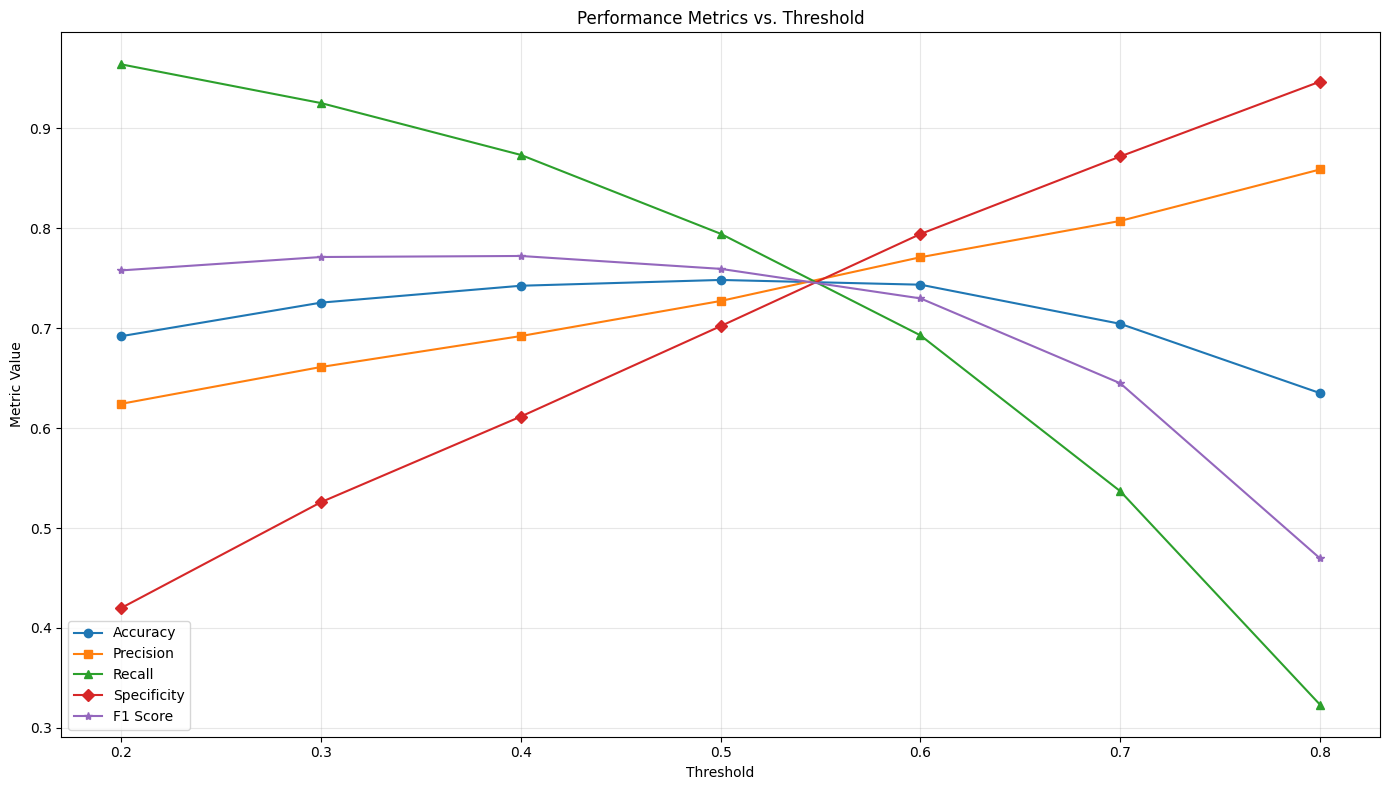

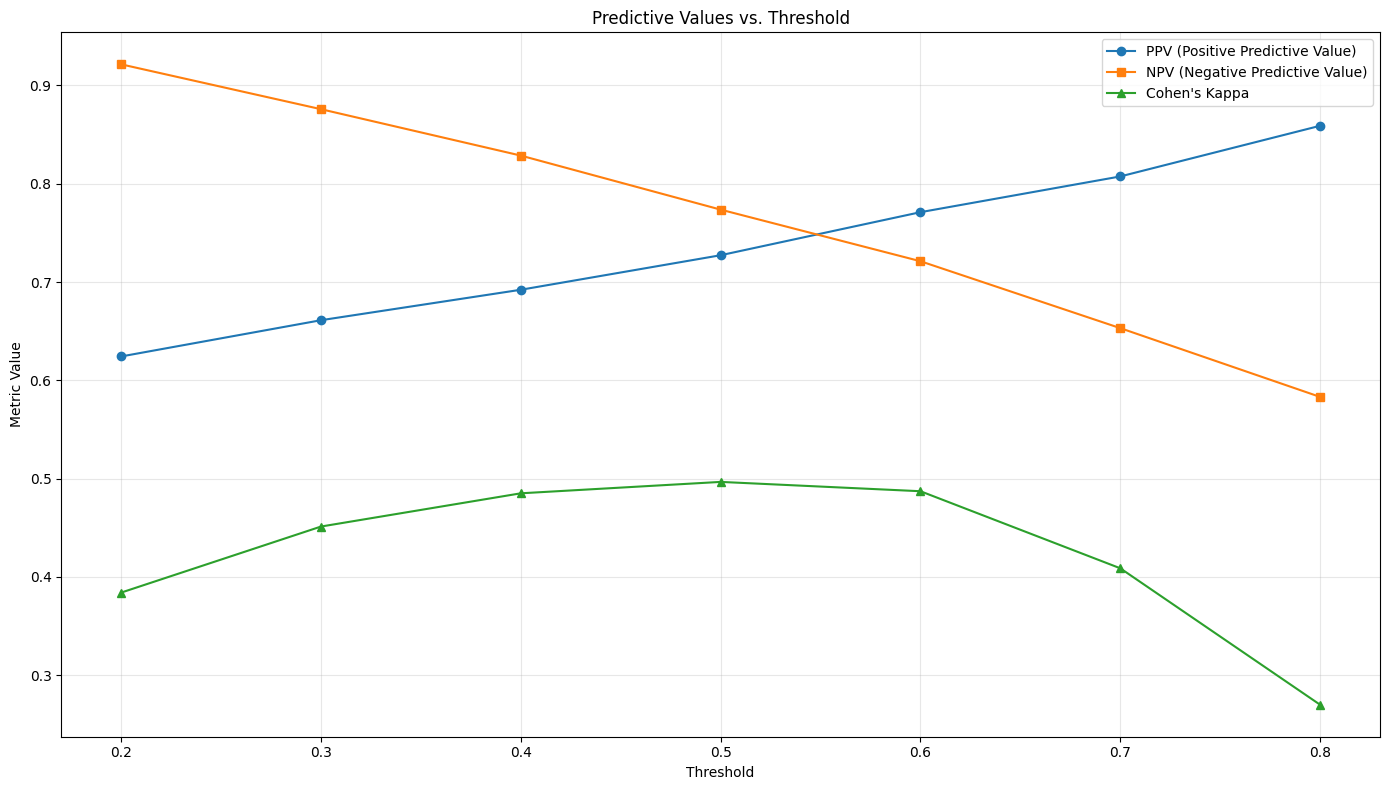

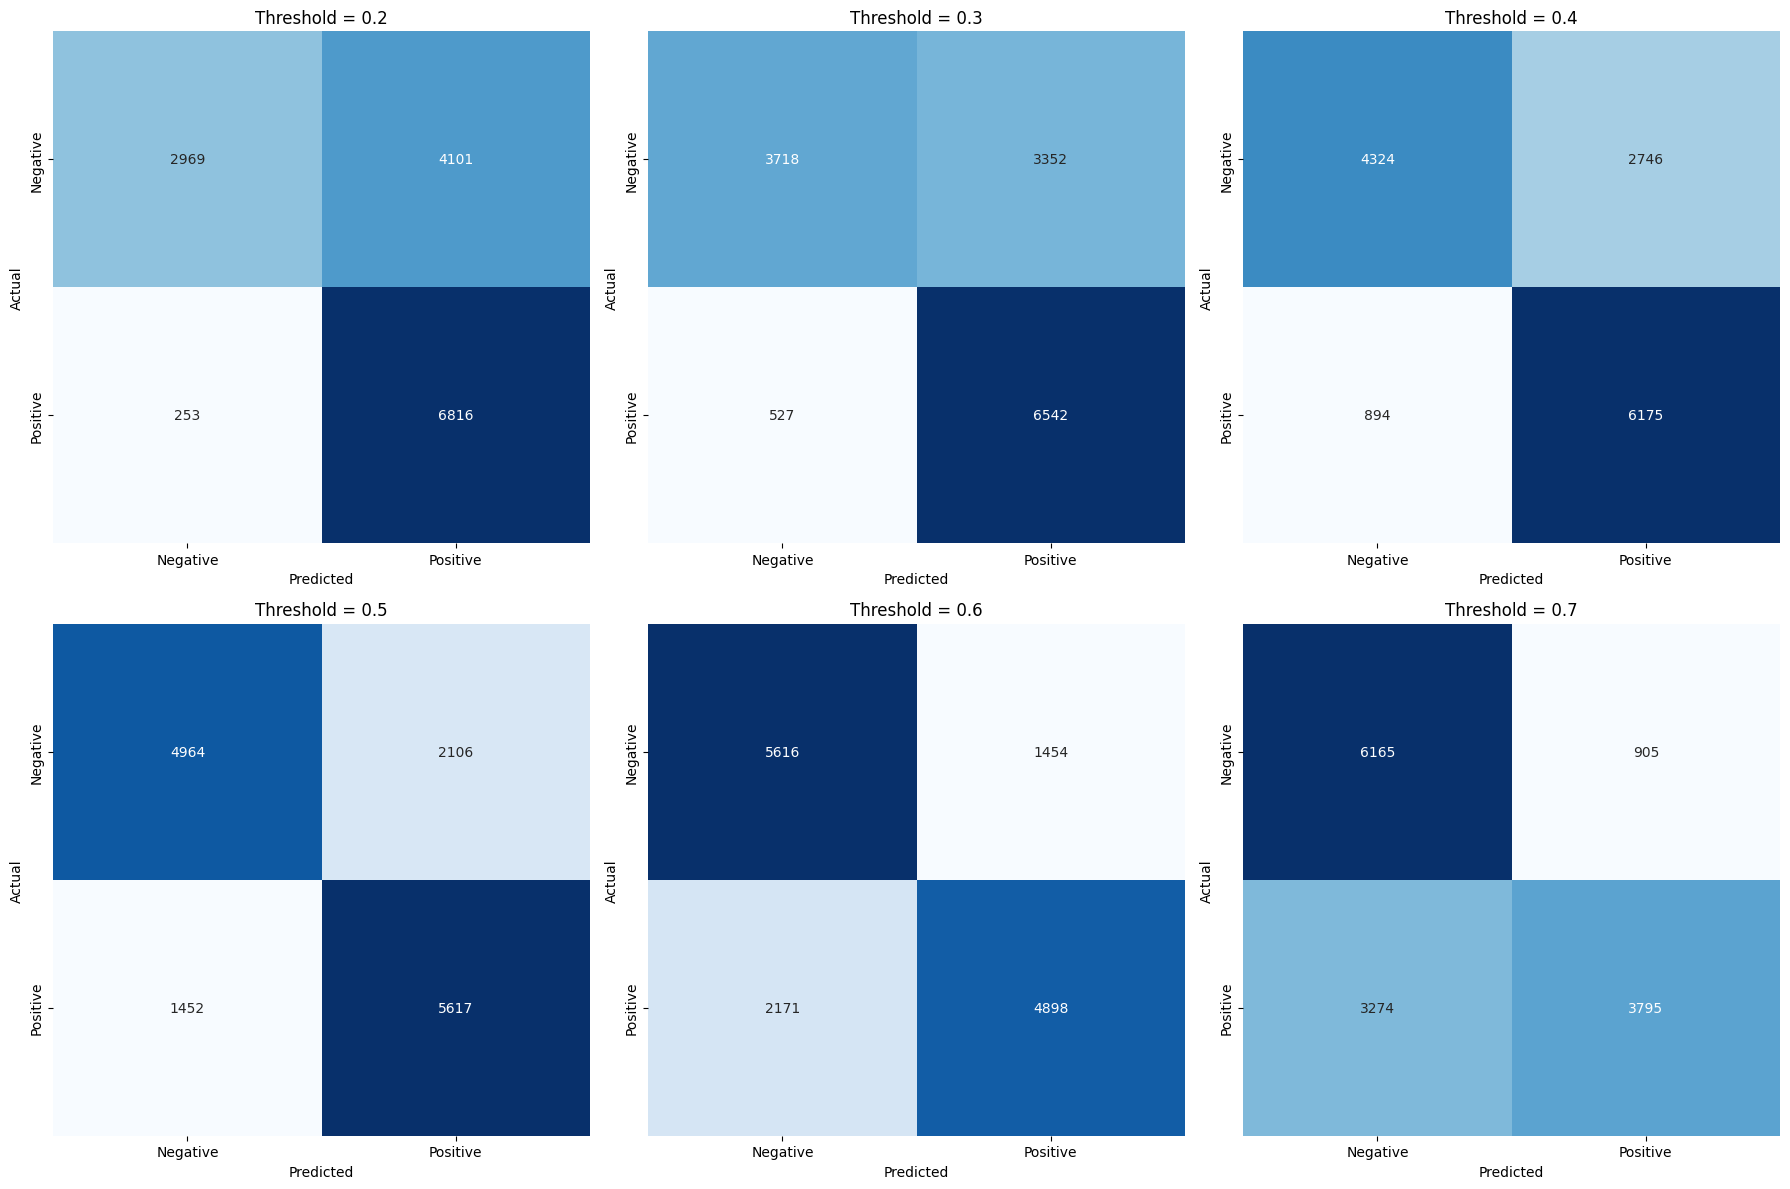


=== Clinical Interpretation of Results ===

Best F1 score at threshold 0.40:
Precision: 0.6922
Recall: 0.8735
F1 Score: 0.7724

Screening threshold (high recall) at 0.20:
Precision: 0.6243
Recall: 0.9642
F1 Score: 0.7579

Confirmatory threshold (high precision) at 0.80:
Precision: 0.8590
Recall: 0.3231
F1 Score: 0.4696

Balanced threshold at 0.50:
Precision: 0.7273
Recall: 0.7946
F1 Score: 0.7595

=== Clinical Recommendations ===
1. For general use: Use threshold of 0.40 for optimal F1 score.
2. For screening purposes: Use threshold of 0.20 to maximize detection of diabetes cases.
3. For confirmatory testing: Use threshold of 0.80 to minimize false positives.
4. For balanced performance: Use threshold of 0.50 for similar precision and recall.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, average_precision_score, 
                           accuracy_score, f1_score, precision_score, recall_score,
                           cohen_kappa_score)
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



# Check class distribution
target_col = 'Diabetes_binary'  # Update this to match your column name
print("Class distribution:")
print(df[target_col].value_counts(normalize=True))

# Split features and target
X = df.drop(target_col, axis=1)
y = df[target_col]

# Remove any non-feature columns
cols_to_drop = ['Unnamed: 0']  # Add any other columns to drop
X = X.drop(cols_to_drop, axis=1, errors='ignore')

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train the CatBoost model
print("Training CatBoost model...")
cb_model = CatBoostClassifier(
    iterations=500, 
    depth=6, 
    learning_rate=0.05, 
    random_seed=RANDOM_STATE,
    verbose=100
)

cb_model.fit(X_train, y_train)

# Get probability predictions on test set
y_pred_proba = cb_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate PR AUC
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"PR AUC: {pr_auc:.4f}")

# Define thresholds to evaluate
thresholds = np.arange(0.2, 0.9, 0.1)

# Collect metrics for each threshold
results = []

for threshold in thresholds:
    # Make binary predictions using this threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Create confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Calculate positive and negative predictive values
    ppv = precision  # Same as precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Store results
    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'kappa': kappa,
        'ppv': ppv,
        'npv': npv,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("\nMetrics across different thresholds:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else x))

# Plot metrics vs threshold
plt.figure(figsize=(14, 8))

# Plot lines
plt.plot(results_df['threshold'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['threshold'], results_df['precision'], marker='s', label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], marker='^', label='Recall')
plt.plot(results_df['threshold'], results_df['specificity'], marker='D', label='Specificity')
plt.plot(results_df['threshold'], results_df['f1_score'], marker='*', label='F1 Score')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot secondary metrics
plt.figure(figsize=(14, 8))

# Plot PPV and NPV
plt.plot(results_df['threshold'], results_df['ppv'], marker='o', label='PPV (Positive Predictive Value)')
plt.plot(results_df['threshold'], results_df['npv'], marker='s', label='NPV (Negative Predictive Value)')
plt.plot(results_df['threshold'], results_df['kappa'], marker='^', label='Cohen\'s Kappa')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Predictive Values vs. Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize confusion matrices at different thresholds
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, threshold in enumerate(thresholds[:6]):  # Plot first 6 thresholds
    # Get confusion matrix values for this threshold
    tn = results_df.loc[results_df['threshold'] == threshold, 'true_negatives'].values[0]
    fp = results_df.loc[results_df['threshold'] == threshold, 'false_positives'].values[0]
    fn = results_df.loc[results_df['threshold'] == threshold, 'false_negatives'].values[0]
    tp = results_df.loc[results_df['threshold'] == threshold, 'true_positives'].values[0]
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f'Threshold = {threshold:.1f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

# Clinical interpretation
print("\n=== Clinical Interpretation of Results ===")

# Find threshold with best F1 score
best_f1_idx = results_df['f1_score'].idxmax()
best_f1_threshold = results_df.loc[best_f1_idx, 'threshold']

print(f"\nBest F1 score at threshold {best_f1_threshold:.2f}:")
print(f"Precision: {results_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"Recall: {results_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"F1 Score: {results_df.loc[best_f1_idx, 'f1_score']:.4f}")

# Find threshold with high recall (screening)
high_recall_threshold = results_df.loc[results_df['recall'] >= 0.85, 'threshold'].min()
if pd.isna(high_recall_threshold):
    high_recall_threshold = results_df.loc[results_df['recall'].idxmax(), 'threshold']
    
high_recall_idx = results_df['threshold'].sub(high_recall_threshold).abs().idxmin()

print(f"\nScreening threshold (high recall) at {high_recall_threshold:.2f}:")
print(f"Precision: {results_df.loc[high_recall_idx, 'precision']:.4f}")
print(f"Recall: {results_df.loc[high_recall_idx, 'recall']:.4f}")
print(f"F1 Score: {results_df.loc[high_recall_idx, 'f1_score']:.4f}")

# Find threshold with high precision (confirmatory)
high_precision_threshold = results_df.loc[results_df['precision'] >= 0.85, 'threshold'].min()
if pd.isna(high_precision_threshold):
    high_precision_threshold = results_df.loc[results_df['precision'].idxmax(), 'threshold']
    
high_precision_idx = results_df['threshold'].sub(high_precision_threshold).abs().idxmin()

print(f"\nConfirmatory threshold (high precision) at {high_precision_threshold:.2f}:")
print(f"Precision: {results_df.loc[high_precision_idx, 'precision']:.4f}")
print(f"Recall: {results_df.loc[high_precision_idx, 'recall']:.4f}")
print(f"F1 Score: {results_df.loc[high_precision_idx, 'f1_score']:.4f}")

# Find threshold with balanced precision/recall
balanced_idx = abs(results_df['precision'] - results_df['recall']).idxmin()
balanced_threshold = results_df.loc[balanced_idx, 'threshold']

print(f"\nBalanced threshold at {balanced_threshold:.2f}:")
print(f"Precision: {results_df.loc[balanced_idx, 'precision']:.4f}")
print(f"Recall: {results_df.loc[balanced_idx, 'recall']:.4f}")
print(f"F1 Score: {results_df.loc[balanced_idx, 'f1_score']:.4f}")

# Clinical recommendations
print("\n=== Clinical Recommendations ===")
print(f"1. For general use: Use threshold of {best_f1_threshold:.2f} for optimal F1 score.")
print(f"2. For screening purposes: Use threshold of {high_recall_threshold:.2f} to maximize detection of diabetes cases.")
print(f"3. For confirmatory testing: Use threshold of {high_precision_threshold:.2f} to minimize false positives.")
print(f"4. For balanced performance: Use threshold of {balanced_threshold:.2f} for similar precision and recall.")